# 8.Diamond structure with GPAW and WannierBerri
This tutorial demonstrates how to wannierize a **spinless** bandstructure of diamond

## Prerequisites
Make sure you have installed the following packages:

```
pip install wannierberri gpaw ase irrep
```

## Step 1: Gpaw calculation

### 1.1 self-consistent calculation

In [1]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, MixerSum
from irrep.spacegroup import SpaceGroup
seed = "diamond"

a = 3.227

lattice = a * (np.ones((3, 3)) - np.eye(3)) / 2
positions = np.array(
    [
        [0, 0, 0],
        [1 / 4, 1 / 4, 1 / 4],
    ]
)
typeat = [1, 1]

atoms = Atoms(
    "C2", cell=lattice, pbc=[1, 1, 1], scaled_positions=positions
)


calc = GPAW(
    mode=PW(500),
    xc="PBE",
    symmetry={'symmorphic': False},
    kpts={"size": [8, 8, 8], "gamma": True},
    convergence={"density": 1e-6},
    mixer=MixerSum(0.25, 8, 100),
    txt=f"{seed}-scf.txt"
)

atoms.calc = calc
atoms.get_potential_energy()
calc.write(f"{seed}-scf.gpw", mode="all")


### Non-self-consistent calculation in the irreducible Brillouin zone

Now we get the list of irreducible k-points (using irrep.SpaceGroup object) and perform a non-self-consistent calculation only on these k-points. 
We use irrep (instead of internal GPAW symmetrization), because it cann account for non-symmorphic symmetries, and also magnetic symmetries (see other tutorials)

In [2]:
calc_scf = GPAW(f'{seed}-scf.gpw', txt=None)
sg = SpaceGroup.from_gpaw(calc_scf)
sg.show()
irred_kpt = sg.get_irreducible_kpoints_grid((4, 4, 4))
calc_nscf_irred = calc_scf.fixed_density(
    kpts=irred_kpt,
    symmetry={'symmorphic': False},
    nbands=20,
    convergence={'bands': 20},
    txt=f'{seed}-nscf-irred.txt')
calc_nscf_irred.write(f'{seed}-nscf.gpw', mode='all')

typat used for spacegroup detection (accounting magmoms): [6 6]


 ---------- CRYSTAL STRUCTURE ---------- 


Cell vectors in angstroms:

      Vectors of DFT cell       
a0 =  0.0000   1.6135   1.6135  
a1 =  1.6135   0.0000   1.6135  
a2 =  1.6135   1.6135   0.0000  



 ---------- SPACE GROUP ----------- 


Space group: Fd-3m1' (# 227.129)
Number of symmetries: 96 (mod. lattice translations)

 ### 1 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [kx, ky, kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [ 0.091821 -0.314892  0.944676] ; angle =  0 , inversion: False, time reversal: False

 ### 2 

rotation : |  1   0   0 |
           |  0   1   0 |
           |  0   0   1 |


 gk = [-kx, -ky, -kz]

translation         :  [   0.0000   0.0000   0.0000 ] 

axis: [ 0.091821 -0.314892  0.944676] ; angle =  0 , inversion: False, time reversal: True

 ### 3 

rotation : |  1   1   1 |
           |  0   0  -1 |
           | -1   0   

### Compute the dft bandstructure along a high-symmetry path

This is done to compare with the wannierized bandstructure later.

In [3]:
calc_bands = GPAW(f"{seed}-scf.gpw",).fixed_density(
    nbands=16,
    symmetry='off',
    kpts={'path': 'WLGXWKG', 'npoints': 60},
    convergence={'bands': 8})


  ___ ___ ___ _ _ _  
 |   |   |_  | | | | 
 | | | | | . | | | | 
 |__ |  _|___|_____|  25.7.0
 |___|_|             

User:   stepan@C3MP-C019202L
Date:   Wed Oct 22 03:47:27 2025
Arch:   x86_64
Pid:    346977
CWD:    /home/stepan/github/WannierBerri-tutorial/tutorials/8_GPAW/8_1_diamond
Python: 3.12.12
gpaw:   /home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/gpaw
_gpaw:  /home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/
        _gpaw.cpython-312-x86_64-linux-gnu.so
ase:    /home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/ase (version 3.26.0)
numpy:  /home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/numpy (version 2.3.4)
scipy:  /home/stepan/github/WannierBerri-tutorial/.conda/lib/python3.12/site-packages/scipy (version 1.16.2)
libxc:  5.2.3
units:  Angstrom and eV
cores: 1
OpenMP: False
OMP_NUM_THREADS: 1

Input parameters:
  convergence: {bands: 8}
  gpts: [12 12 12]
  

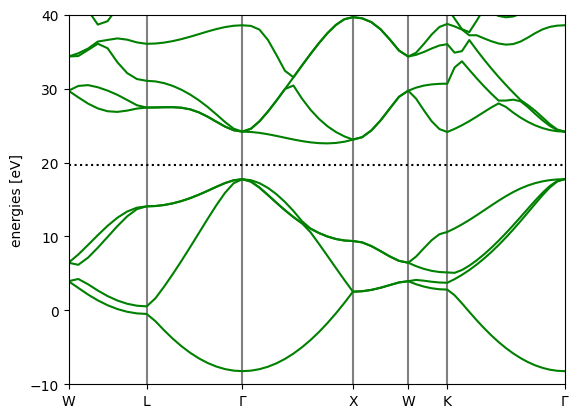

<Axes: ylabel='energies [eV]'>

In [5]:

bs_dft = calc_bands.band_structure()
bs_dft.plot(show=True, emax=40.0)

## Step 2: Wannierization

#### 2.1 select projections

In this case we use sp3 projections on each carbon atom.

In [6]:
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files.w90data import Wannier90data
positions = sg.positions

proj_sp3 = Projection(
    position_num=positions,
    orbital='sp3',
    spacegroup=sg,
    rotate_basis=True
)
proj_set = ProjectionsSet(projections=[proj_sp3])


2025-10-22 03:48:14,956	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


### create the "w90 files"

Here we are NOT using the gpaw-wannier90 interface, and actually not creating the w90 files, but directly access the wavefunctions from the GPAW calculation, use symmetry operations from irrep, and create the necessary data to be used with wannierberri. Those files still retain the same naming convention as the w90 files for consistency, but htey are binary npz files, which are convenient to work with numpy

In [7]:

# seedname_ref = os.path.join(path_data, "diamond-irred")
w90data = Wannier90data().from_gpaw(
    calculator=calc_nscf_irred,
    spin_channel=0,
    projections=proj_set,
    select_grid=(4,4,4),
    seedname="diamond-wannnier",
    irreducible=True,
    files=["amn", "mmn", "eig", "symmetrizer"],
    unitary_params=dict(error_threshold=0.1,
                        warning_threshold=0.01,
                        nbands_upper_skip=8),
)


finding num points from 1 projections
got irreducible=True, mp_grid=None, seedname=diamond-wannnier, files=['amn', 'mmn', 'eig', 'symmetrizer'], read_npz_list=None, write_npz_list=None, projections=ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.0, 0.0, 0.0:['sp3'] with 8 Wannier functions on 2 points (4 per site), unk_grid=None, normalize=True
self.irreducible=True
mpgrid = [4 4 4], 8


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:185: UserWarning: Failed to read symmetrizer from diamond-wannnier.symmetrizer.npz: [Errno 2] No such file or directory: 'diamond-wannnier.symmetrizer.npz'
  warnings.warn(f"Failed to read symmetrizer from {fname}: {e}")


orbitals = ['sp3']
calculating Wannier functions for sp3 at [[0.   0.   0.  ]
 [0.25 0.25 0.25]]
D.shape [(8, 48, 8, 8)]
num_wann 8
D_wann_block_indices [[0 8]]
saving to diamond-wannnier.symmetrizer.npz : 
saving to diamond-wannnier.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.0, 0.0, 0.0:['sp3'] with 8 Wannier functions on 2 points (4 per site)
saving to diamond-wannnier.amn.npz : 
mpgrid = [4 4 4], 64
NK= 64, selected_kpoints = [0 1 2 3 4 5 6 7], kptirr = [0 1 2 3 4 5 6 7]
Shells found with weights [0.52755554] and tolerance 3.894270040588992e-16
saving to diamond-wannnier.mmn.npz : 


In [8]:
w90data.wannierise(
    froz_min=-10,
    froz_max=30,
    num_iter=1000,
    conv_tol=1e-10,
    print_progress_every=20,
    sitesym=True,
    localise=True
)

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


Symmetrizer_Uirr initialized for ikirr=0, kpt=0, [0. 0. 0.] with 48 symmetries, max error in included blocks: 9.981980985815973e-12 ; excluded bands are [18 19] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=1, kpt=1, [0.   0.   0.25] with 6 symmetries, max error in included blocks: 7.1253546418360705e-09 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=2, kpt=2, [0.  0.  0.5] with 12 symmetries, max error in included blocks: 2.9212327752830694e-09 ; excluded bands are [] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=3, kpt=3, [0.   0.25 0.25] with 8 symmetries, max error in included blocks: 1.548361409101639e-09 ; excluded bands are [19] out of 20 total bands (accuracy threshold 1e-06)
Symmetrizer_Uirr initialized for ikirr=4, kpt=4, [0.   0.25 0.5 ] with 2 symmetries, max error in included blocks: 3.946495907847236e-17 ; excluded bands are 

### Create the System object to be used in WannierBerri calculations

It is called "System_w90" class, although it now does not use the w90 wannierization, but the class is the same.

In [9]:
from wannierberri.system.system_w90 import System_w90

system = System_w90(w90data=w90data, berry=True)

setting Rvec
setting AA..
setting AA - OK
Real-space lattice:
 [[0.     1.6135 1.6135]
 [1.6135 0.     1.6135]
 [1.6135 1.6135 0.    ]]
Number of wannier functions: 8
Number of R points: 123
Recommended size of FFT grid [4 4 4]


## Compute the wannierized bandstructure along the high-symmetry path

### create the k path for wannierberri

In [10]:
from wannierberri.evaluate_k import evaluate_k_path

kpoints = {
    'G': [0.0, 0.0, 0.0],
    'X': [0.5, 0.0, 0.5],
    'W': [0.5, 0.25, 0.75],
    'L': [0.5, 0.5, 0.5],
    'K': [0.375, 0.375, 0.75],
}

path_labels = "WLGXWKG"

path , bands_wannier= evaluate_k_path(system, 
                                nodes=[kpoints[label] for label in path_labels],
                                labels=list(path_labels),
                                length=100,
                                return_path=True)  # length~=2pi/dk




Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x74fae8d45b80>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x74facfdfd400> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x74fae8d45b80>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 140 points and labels {0: 'W', 22: 'L', 49: 'G', 80: 'X', 95: 'W', 106: 'K', 139: 'G'}
generating K_list
Done 
Done, sum of weights:140.0

##

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


### Plot the bandstructures

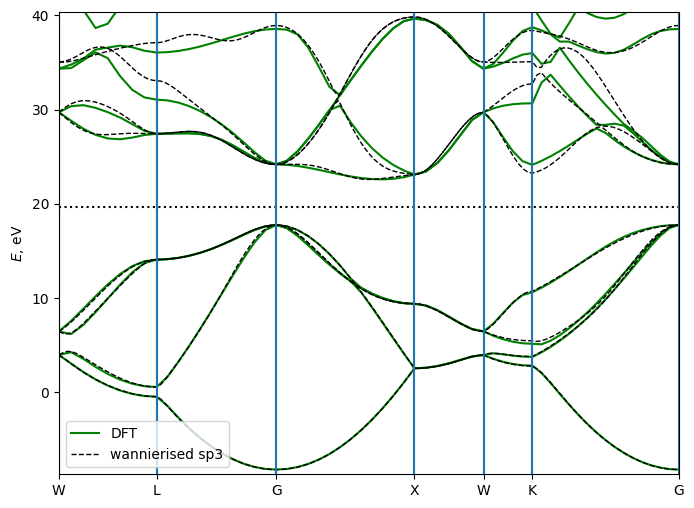

In [11]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
bs_dft.plot(show=False, emax=40.0, ax=ax, label="DFT")
bands_wannier.plot_path_fat(path=path,
                       label="wannierised sp3",
                        # linecolor="orange",
                        axes=ax,
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='--', lw=1.0),
    )
plt.show()



One can see that the wannierized bandstructure (dashed lines) well reproduces the DFT bandstructure (solid lines) in the energy window of interest. Note, that we started from a very coarse DFT grid of 4,4,4 k-points, and still obtained a good agreement after wannierization. You may try to increase the grid on the nscf step, and see how it improves the agreement further.

## Bonding and antibonding states

Another option for projections is to use bonding and antibonding states. For that we place the wannier centers on the centers of the bonds, and use s-type projections (or bonding and pz-type for antibonding states, with the "z-axis" along the bond direction [111]. Note, that we specify only one bond position, the other 3 are generated by symmetry operations, and their "zaxis" are also rotated accordingly. 

Bonding states describe the valence bands, while antibonding states describe the conduction bands, so they can be wannierised separately.

In [12]:
proj_bonding = Projection(
    position_num=[1/8, 1/8, 1/8],
    orbital='s',
    spacegroup=sg,
    rotate_basis=True
)
proj_antibonding = Projection(
    position_num=[1/8, 1/8, 1/8],
    orbital='pz',
    zaxis=[1,1,1],
    rotate_basis=True,
    spacegroup=sg)

proj_set_bonding = ProjectionsSet(projections=[proj_bonding, proj_antibonding])


# seedname_ref = os.path.join(path_data, "diamond-irred")
w90data_bonding= Wannier90data().from_gpaw(
    calculator=calc_nscf_irred,
    spin_channel=0,
    projections=proj_set_bonding,
    select_grid=(4,4,4),
    seedname="diamond-wannnier-bonding",
    irreducible=True,
    files=["amn", "mmn", "eig", "symmetrizer"],
    unitary_params=dict(error_threshold=0.1,
                        warning_threshold=0.01,
                        nbands_upper_skip=8),
)

w90data_bonding.wannierise(
    froz_min=-10,
    froz_max=30,
    num_iter=1000,
    conv_tol=1e-10,
    print_progress_every=20,
    sitesym=True,
    localise=True
)

system_bonding = System_w90(w90data=w90data_bonding, berry=True)
bands_wannier_bonding = evaluate_k_path(system_bonding,
                                        path=path,
                                        return_path=False)

finding num points from 2 projections
got irreducible=True, mp_grid=None, seedname=diamond-wannnier-bonding, files=['amn', 'mmn', 'eig', 'symmetrizer'], read_npz_list=None, write_npz_list=None, projections=ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.125, 0.125, 0.125:['s'] with 4 Wannier functions on 4 points (1 per site)
Projection 0.125, 0.125, 0.125:['pz'] with 4 Wannier functions on 4 points (1 per site), unk_grid=None, normalize=True
self.irreducible=True
mpgrid = [4 4 4], 8


/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/w90files/w90data.py:185: UserWarning: Failed to read symmetrizer from diamond-wannnier-bonding.symmetrizer.npz: [Errno 2] No such file or directory: 'diamond-wannnier-bonding.symmetrizer.npz'
  warnings.warn(f"Failed to read symmetrizer from {fname}: {e}")


orbitals = ['s']
orbitals = ['pz']
calculating Wannier functions for s at [[0.125 0.125 0.125]
 [0.625 0.125 0.125]
 [0.125 0.125 0.625]
 [0.125 0.625 0.125]]
calculating Wannier functions for pz at [[0.125 0.125 0.125]
 [0.625 0.125 0.125]
 [0.125 0.125 0.625]
 [0.125 0.625 0.125]]
D.shape [(8, 48, 4, 4), (8, 48, 4, 4)]
num_wann 8
D_wann_block_indices [[0 4]
 [4 8]]
saving to diamond-wannnier-bonding.symmetrizer.npz : 
saving to diamond-wannnier-bonding.eig.npz : 
Creating amn. Using projections_set 
ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.125, 0.125, 0.125:['s'] with 4 Wannier functions on 4 points (1 per site)
Projection 0.125, 0.125, 0.125:['pz'] with 4 Wannier functions on 4 points (1 per site)
saving to diamond-wannnier-bonding.amn.npz : 
mpgrid = [4 4 4], 64
NK= 64, selected_kpoints = [0 1 2 3 4 5 6 7], kptirr = [0 1 2 3 4 5 6 7]
Shells found with weights [0.52755554] and tolerance 3.894270040588992e-16
saving to diamond-wannnier-bonding.mmn.npz

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.403375000000    0.403375000000    0.403375000000   |     0.924526485432
  0.403375000000    1.210125000000    1.210125000000   |     0.924526485432
  1.210125000000    1.210125000000    0.403375000000   |     0.924526485432
  1.210125000000    0.403375000000    1.210125000000   |     0.924526485432
  0.403375000000    0.403375000000    0.403375000000   |     8.132041709224
  0.403375000000    1.210125000000    1.210125000000   |     8.132041709224
  1.210125000000    1.210125000000    0.403375000000   |     8.132041709224
  1.210125000000    0.403375000000    1.210125000000   |     8.132041709224
------------------------------------------------

/home/stepan/github/wannier-berri-work/wannier-berri-soc-nscf/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


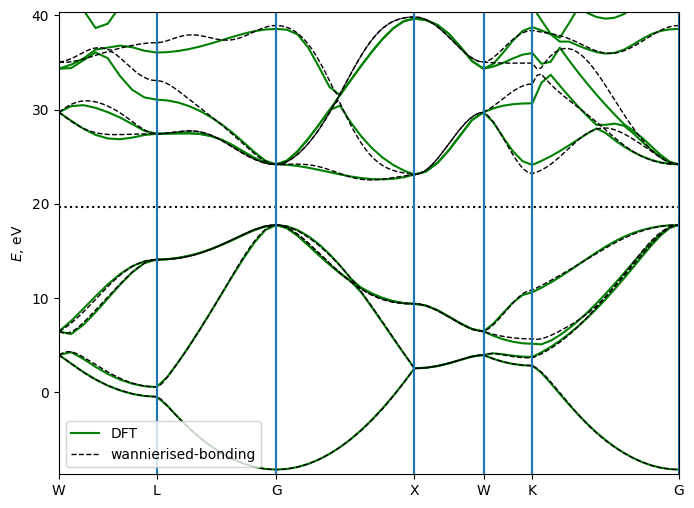

In [13]:
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(8,6))
bs_dft.plot(filename='bandstructure.png', show=False, emax=40.0, ax=ax, label="DFT")
bands_wannier_bonding.plot_path_fat(path=path,
                       label="wannierised-bonding",
                        # linecolor="orange",
                        axes=ax,
                        close_fig=False,
                        show_fig=False,
                        kwargs_line=dict(linestyle='--', lw=1.0),
    )
plt.show()

### Save the system objects for later use

In [14]:
system_bonding.save_npz("system-diamond-bonding")
system.save_npz("system-diamond-sp3")

# load the system later
from wannierberri.system.system_R import System_R 
system_loaded = System_R().load_npz("system-diamond-sp3")

saving system of class System_w90 to system-diamond-bonding
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup']
saving num_wann
saving num_wann to system-diamond-bonding/num_wann.npz
 - Ok!
saving real_lattice
saving real_lattice to system-diamond-bonding/real_lattice.npz
 - Ok!
saving iRvec
saving iRvec to system-diamond-bonding/iRvec.npz
 - Ok!
saving periodic
saving periodic to system-diamond-bonding/periodic.npz
 - Ok!
saving is_phonon
saving is_phonon to system-diamond-bonding/is_phonon.npz
 - Ok!
saving wannier_centers_cart
saving wannier_centers_cart to system-diamond-bonding/wannier_centers_cart.npz
 - Ok!
saving pointgroup
saving pointgroup to system-diamond-bonding/pointgroup.npz
 - Ok!
saving Ham - Ok!
saving AA - Ok!
saving system of class System_w90 to system-diamond-sp3
 properties: ['num_wann', 'real_lattice', 'iRvec', 'periodic', 'is_phonon', 'wannier_centers_cart', 'pointgroup']
saving num_wann
saving num_wa